In [2]:
# This notebook identifies a ball in radar data
# range_doppler_notebook has the basics of how to get the basics (what was I thinking when I wrote this)

import h5py
import numpy as np
import matplotlib.pyplot as plt
from radar_ffts import range_doppler_fft, range_doppler_sum, azimuth_fft, azimuth_sum
from cfar import cfar, clean_cfar
from radar_functions import get_measurement_parameters, get_data_files, range_doppler_map, cfar_map, make_map, save_map

# This was before creating the new functions
# from radar_functions import range_doppler_map, get_measurement_parameters, cfar_map, save_range_doppler_map, save_cfar_map, get_data_files


c = 299792458 # metres per second - need this

In [3]:
# Making data lists
#moving_back_test = h5py.File('../4022S_data/undergrad_testset/Experiment_moving_target_back_data.hdf5', 'r') # Read in the file
#one_meter_centre_test = h5py.File('../4022S_data/undergrad_testset/Experiment_stationary_target_1m_1_data.hdf5','r')
#two_meter_centre_test = h5py.File('../4022S_data/undergrad_testset/Experiment_stationary_target_2m_1_data.hdf5','r')

#golfball_testset1 = '../4022S_data/golfball_testset1/'
#session2_directory = '../4022S_data/session2/'
#session3_directory = ['../4022S_data/session3/config1_rob/']
#session4_directory = ['../4022S_data/session4/calibration/']
#tennis_ball_tests = get_data_files(session2_preface) # This works pretty well. Should make new folders for different tests/sets, but this works as a good basis

#session4 = get_data_files(session4_directory[0])
#session3_rob = get_data_files(session3_directory[0])

session5_directory = ['../4022S_data/session5/rob_config/test1_calibration/',
                    '../4022S_data/session5/rob_config/test2_motion_calibration/',
                    '../4022S_data/session5/rob_config/test3_basketball_throw/',
                    '../4022S_data/session5/rob_config/test4_tennis_throw/',
                    '../4022S_data/session5/rob_config/test5_golf_throw/',
                    '../4022S_data/session5/rob_config/test6_soccer_roll/',
                    '../4022S_data/session5/rob_config/test7_tennis_roll/',
                    '../4022S_data/session5/rob_config/test8_golf_roll/',
                    '../4022S_data/session5/rob_config/test9_tennis_golf_similar_roll/']

# session5_directory = ['../4022S_data/session5/rob_config/test8_golf_roll/',
#                       '../4022S_data/session5/rob_config/test9_tennis_golf_similar_roll/']

session5_data = []

for i in range(len(session5_directory)):
    loaded_data = get_data_files(session5_directory[i])
    session5_data.append(loaded_data)

tests_in_question = session5_data

freq_slope_const, number_of_samples_per_chirp, sample_rate, Tdata, bandwidth, range_bin_size, velocity_resolution = get_measurement_parameters(tests_in_question[0][0])

session5_frames_directory = ['frames/test1_calibration/',
                             'frames/test2_motion_calibration/',
                             'frames/test3_basketball_throw/',
                             'frames/test4_tennis_throw/',
                             'frames/test5_golf_throw/',
                             'frames/test6_soccer_roll/',
                             'frames/test7_tennis_roll/',
                             'frames/test8_golf_roll/',
                             'frames/test9_tennis_golf_similar_roll/']

# session5_frames_directory = ['frames/test8_golf_roll/',
#                              'frames/test9_tennis_golf_similar_roll/']


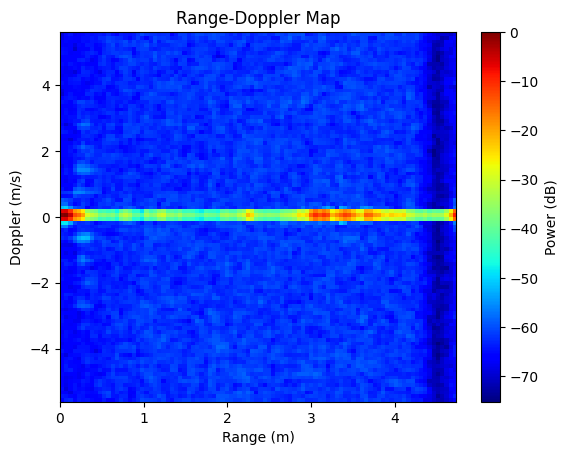

In [3]:
# Just want to output a single channel RDM
straight_test_number = 0
straight_frame_number = 150


target_test = session5_data[5][straight_test_number]

rd_map = range_doppler_map(target_test, straight_frame_number, True)

C:\Users\harry\AppData\Local\Temp\ipykernel_12304\3842695661.py:32: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(X, Y, range_azimuth_data.T, cmap='jet', shading='auto')


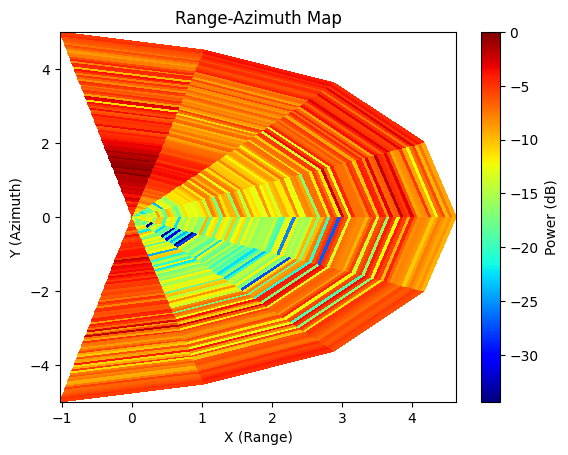

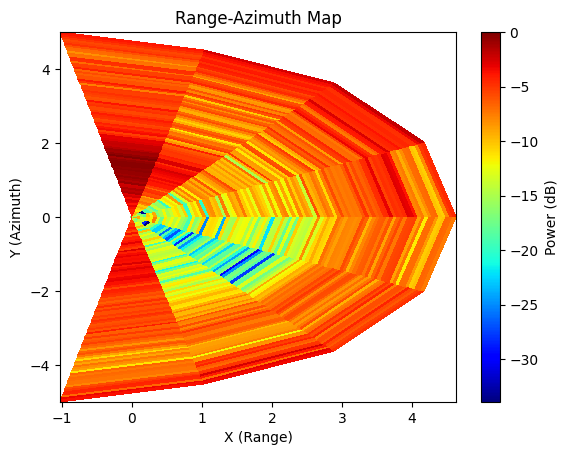

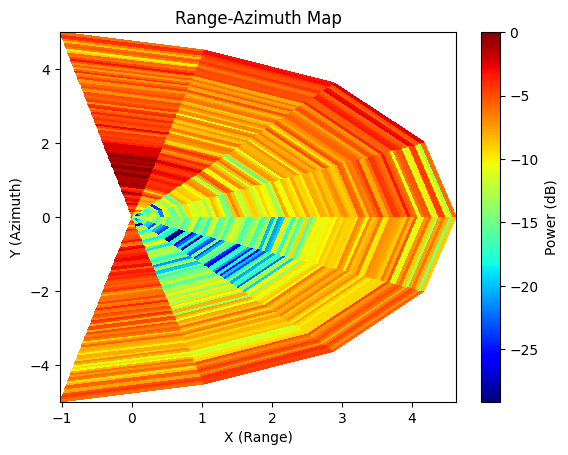

In [23]:
# Desperate attempt at getting range-azimuth data

max_range_value = range_bin_size * len(frame_data[:,0,0])
straight_frame_number = 330
straight_test_number = 0

left_frame_number = 97
left_test_number = 3

right_frame_number = 77
right_test_number = 5

def range_angle_map(frame_number, test_number,n):
    direction = ["straight", "left", "right"]
    target_test = session5_data[5][test_number]
    frame_data = target_test[f'Sensors/TI_Radar/Data/Frame_{frame_number}/frame_data']
    range_azimuth_data = azimuth_sum(azimuth_fft(frame_data,0))
    
    # Define the range and azimuth values
    range_bins = np.linspace(0, max_range_value, range_azimuth_data.shape[0])  # replace max_range_value with the maximum range
    angle_bins = np.linspace(-np.pi/2, np.pi/2, range_azimuth_data.shape[1])  # adjust if azimuth angle is larger

    # Create meshgrid for range and angle
    R, Theta = np.meshgrid(range_bins, angle_bins)

    # Convert to Cartesian coordinates for plotting
    X = R * np.cos(Theta)
    Y = R * np.sin(Theta)

    # Plot using pcolormesh to respect the bin stretching in a radial fashion
    plt.figure()
    plt.pcolormesh(X, Y, range_azimuth_data.T, cmap='jet', shading='auto')
    plt.colorbar(label='Power (dB)')
    # plt.title(f'{direction[n]} Range-Azimuth Map (Cone Representation)')
    plt.title("Range-Azimuth Map")
    plt.xlabel('X (Range)')
    plt.ylabel('Y (Azimuth)')
    plt.show()

range_angle_map(straight_frame_number,straight_test_number, 0)
range_angle_map(left_frame_number, left_test_number, 1)
range_angle_map(right_frame_number,right_test_number, 2)


In [ ]:
# This version lets us just work on one experiment rather than the entire dataset
# An experiment being what kind of data was captured
# Dataset has experiments in it, which have tests in them

experiment_number = int(input("What test are we doing")) - 1

target_tests = session5_data[experiment_number] # Change this as needed


straight_test_number = 0
straight_frame_number = 0

test_being_saved = target_tests[straight_test_number]
while True:
        try:
            print(f'Saving range-doppler map {straight_test_number} frame {straight_frame_number} into {session5_frames_directory[experiment_number]}')
            rd_map = range_doppler_map(test_being_saved, straight_frame_number, False)
            save_map(rd_map,
                        range_bin_size,
                        velocity_resolution,
                        False,
                        f'range-doppler map test {straight_test_number} frame {straight_frame_number}',
                        session5_frames_directory[experiment_number])
            
            print(f'Saving cfar map {straight_test_number} frame {straight_frame_number} into {session5_frames_directory[experiment_number]}')
            cf_map = cfar_map(rd_map, range_bin_size, velocity_resolution, False)
            save_map(cf_map,                                                        # Target map
                        range_bin_size,                                                # range bins
                        velocity_resolution,                                           #
                        True,
                        f'cfar map test {straight_test_number} frame {straight_frame_number}',     # name
                        session5_frames_directory[experiment_number])                  # directory saved to
            
            straight_frame_number += 1
        except:
            print("Done!")
            straight_frame_number = 0
            straight_test_number += 1
            break 


In [4]:
# Need to take all frames of a target and generate all the maps
straight_frame_number = 0
straight_test_number = 0

#Session 5 is broken up into a number of experiments, each containing a number of tests

for experiment_number in range(len(session5_data)):
    for test_being_saved in session5_data[experiment_number]:
        while True:
            try:
                print(f'Saving range-doppler map {straight_test_number} frame {straight_frame_number} into {session5_frames_directory[experiment_number]}')
                rd_map = range_doppler_map(test_being_saved, straight_frame_number, False)
                save_map(rd_map,
                         range_bin_size,
                         velocity_resolution,
                         False,
                         f'range-doppler map test {straight_test_number} frame {straight_frame_number}',
                         session5_frames_directory[experiment_number])
                
                print(f'Saving cfar map {straight_test_number} frame {straight_frame_number} into {session5_frames_directory[experiment_number]}')
                cf_map = cfar_map(rd_map, range_bin_size, velocity_resolution, False)
                save_map(cf_map,                                                        # Target map
                         range_bin_size,                                                # range bins
                         velocity_resolution,                                           #
                         True,
                         f'cfar map test {straight_test_number} frame {straight_frame_number}',     # name
                         session5_frames_directory[experiment_number])                  # directory saved to
                
                straight_frame_number += 1
            except:
                print("Onto the next test")
                straight_frame_number = 0
                straight_test_number += 1
                break

Saving range-doppler map 0 frame 0 into frames/test8_golf_roll/
Saving cfar map 0 frame 0 into frames/test8_golf_roll/
Saving range-doppler map 0 frame 1 into frames/test8_golf_roll/
Saving cfar map 0 frame 1 into frames/test8_golf_roll/
Saving range-doppler map 0 frame 2 into frames/test8_golf_roll/
Saving cfar map 0 frame 2 into frames/test8_golf_roll/
Saving range-doppler map 0 frame 3 into frames/test8_golf_roll/
Saving cfar map 0 frame 3 into frames/test8_golf_roll/
Saving range-doppler map 0 frame 4 into frames/test8_golf_roll/
Saving cfar map 0 frame 4 into frames/test8_golf_roll/
Saving range-doppler map 0 frame 5 into frames/test8_golf_roll/
Saving cfar map 0 frame 5 into frames/test8_golf_roll/
Saving range-doppler map 0 frame 6 into frames/test8_golf_roll/
Saving cfar map 0 frame 6 into frames/test8_golf_roll/
Saving range-doppler map 0 frame 7 into frames/test8_golf_roll/
Saving cfar map 0 frame 7 into frames/test8_golf_roll/
Saving range-doppler map 0 frame 8 into frames/t

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x797f181414c0>>
Traceback (most recent call last):
  File "/usr/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


Saving range-doppler map 2 frame 303 into frames/test8_golf_roll/
Saving cfar map 2 frame 303 into frames/test8_golf_roll/
